In [1]:
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

tf.compat.v1.enable_eager_execution()
assert tf.executing_eagerly()

In [2]:
epochs = 20
batch_size = 500

DP-SGD has three privacy-specific hyperparameters and one existing hyperamater that you must tune:

1. `l2_norm_clip` (float) - The maximum Euclidean (L2) norm of each gradient that is applied to update model parameters. This hyperparameter is used to bound the optimizer's sensitivity to individual training points. 
2. `noise_multiplier` (float) - The amount of noise sampled and added to gradients during training. Generally, more noise results in better privacy (often, but not necessarily, at the expense of lower utility).
3.   `microbatches` (int) - Each batch of data is split in smaller units called microbatches. By default, each microbatch should contain a single training example. This allows us to clip gradients on a per-example basis rather than after they have been averaged across the minibatch. This in turn decreases the (negative) effect of clipping on signal found in the gradient and typically maximizes utility. However, computational overhead can be reduced by increasing the size of microbatches to include more than one training examples. The average gradient across these multiple training examples is then clipped. The total number of examples consumed in a batch, i.e., one step of gradient descent, remains the same. The number of microbatches should evenly divide the batch size. 

In [3]:
l2_norm_clip = 0.3
noise_multiplier = 1
num_microbatches = 1

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

Percentile at which to clip norm, based on public data gradients

In [4]:
norm_percentile = 0.8

In [5]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255
train_data = np.expand_dims(train_data, len(train_data.shape))
test_data = np.expand_dims(test_data, len(test_data.shape))

train_labels = np.array(train_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

assert train_data.min() == 0.
assert train_data.max() == 1.
assert test_data.min() == 0.
assert test_data.max() == 1.

In [6]:
from sklearn.model_selection import train_test_split

# test_size refers to private data size
public_data, private_data, public_labels, private_labels = \
    train_test_split(train_data, train_labels, test_size=59/60)

train_dataset = tf.data.Dataset.from_tensor_slices((private_data, private_labels))
# Data is already shuffled
train_dataset = train_dataset.batch(batch_size)
num_batches = private_data.shape[0] // batch_size

In [7]:
print(public_data.shape)
print(public_labels.shape)
print(private_data.shape)
print(private_labels.shape)

(1000, 28, 28, 1)
(1000, 10)
(59000, 28, 28, 1)
(59000, 10)


In [8]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

compute_dp_sgd_privacy.compute_dp_sgd_privacy(
    n=private_labels.shape[0], batch_size=batch_size, noise_multiplier=noise_multiplier, epochs=epochs, delta=1e-5)

DP-SGD with sampling rate = 0.847% and noise_multiplier = 1 iterated over 2360 steps satisfies differential privacy with eps = 3.06 and delta = 1e-05.
The optimal RDP order is 8.0.


(3.0591973590804473, 8.0)

In [9]:
# CNN model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

def cnn_model():
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=train_data.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [10]:
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPAdamGaussianOptimizer

optimizer = DPAdamGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches)

loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [11]:
def l2_norm(arr):
    return np.sqrt(np.sum(np.square(arr)))

def get_public_grads(public_x, public_y, loss_fn, model):
    public_grads = []
    # x needs to have extra dimension for number of examples,
    # even if it's 1 for our case
    public_x = np.expand_dims(public_x, axis=1)
    for x, y in zip(public_x, public_y):
#     for x, y in tqdm(zip(public_x, public_y), total=public_x.shape[0], desc='Public Dataset Iter'):
        with tf.GradientTape() as tape:
            loss_value = loss_fn(y, model(x))
            grad = tape.gradient(loss_value, model.trainable_weights)
        grad_norms = [l2_norm(t.numpy()) for t in grad]
        public_grads.append(grad_norms)
    # Index is (Layer, Example)
    return np.swapaxes(np.asarray(public_grads), 0, 1)

def get_grads_percentile(public_grads, percentile):
    layer_percentiles = []
    for layer in public_grads:
        layer_percentile = np.percentile(np.asarray(layer), norm_percentile, axis=0)
        layer_percentiles.append(layer_percentile)
    return layer_percentiles

def evaluate_model(model, loss_fn, x, y):
    pred = model(x)
    loss = np.mean(loss_fn(y, pred).numpy())
    acc = np.mean(tf.keras.metrics.categorical_accuracy(y, pred).numpy())
    return (loss, acc)

In [12]:
clipped_model = cnn_model()
clipped_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [ ]:
# Iterate over epochs.
clipped_loss_epochs = []
clipped_acc_epochs = []

for epoch in tqdm(range(epochs), desc='Epoch'):
    
    # Evaluate
    loss, acc = evaluate_model(clipped_model, loss_fn, test_data, test_labels)
    print("Epoch %d - Loss: %.4f, Acc: %.4f" % (epoch, loss, acc))
    clipped_loss_epochs.append(loss)
    clipped_acc_epochs.append(acc)

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(tqdm(train_dataset, total=num_batches, desc='Batch')):

        public_grads = get_public_grads(public_data, public_labels, loss_fn, clipped_model)
        grad_percentiles_by_layer = get_grads_percentile(public_grads, norm_percentile)

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape(persistent=True) as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = clipped_model(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss = lambda: loss_fn(y_batch_train, logits)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = optimizer.compute_gradients(loss, clipped_model.trainable_weights, gradient_tape=tape, 
                                                gradient_clips=grad_percentiles_by_layer)

        del tape

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(grads)

Epoch 0 - Loss: 2.3033, Acc: 0.0633


In [ ]:
evaluate_model(clipped_model, loss_fn, test_data, test_labels)

In [ ]:
dpsgd_model = cnn_model()
dpsgd_optimizer = DPAdamGaussianOptimizer(
                        l2_norm_clip=1e20,
                        noise_multiplier=0,
                        num_microbatches=num_microbatches)
dpsgd_model.compile(optimizer=dpsgd_optimizer, loss=loss_fn, metrics=['accuracy'])

In [ ]:
# Iterate over epochs.
dpsgd_loss_epochs = []
dpsgd_acc_epochs = []

for epoch in tqdm(range(epochs), desc='Epoch'):
    
    # Evaluate
    loss, acc = evaluate_model(dpsgd_model, loss_fn, test_data, test_labels)
    print("Epoch %d - Loss: %.4f, Acc: %.4f" % (epoch, loss, acc))
    dpsgd_loss_epochs.append(loss)
    dpsgd_acc_epochs.append(acc)

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(tqdm(train_dataset, total=num_batches, desc='Batch')):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape(persistent=True) as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = dpsgd_model(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss = lambda: loss_fn(y_batch_train, logits)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = optimizer.compute_gradients(loss, dpsgd_model.trainable_weights, gradient_tape=tape)

        del tape

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(grads)

In [ ]:
evaluate_model(dpsgd_model, loss_fn, test_data, test_labels)

In [ ]:
baseline_model = cnn_model()
baseline_model.compile(optimizer='adam',
                       loss=loss_fn, metrics=['accuracy'])

In [ ]:
baseline_model.fit(private_data, private_labels,
              epochs=epochs,
              batch_size=batch_size)

In [ ]:
evaluate_model(baseline_model, loss_fn, test_data, test_labels)

In [25]:
import pandas as pd

metrics = pd.DataFrame({'clipped_loss': clipped_loss_epochs,
                        'dpsgd_loss': dpsgd_loss_epochs,
                        'clipped_acc': clipped_acc_epochs,
                        'dpsgd_acc': dpsgd_acc_epochs})
print(metrics)

    clipped_acc  clipped_loss  dpsgd_acc  dpsgd_loss
0        0.0633      2.303323     0.1123    2.302954
1        0.2970      2.296039     0.2622    2.262195
2        0.3500      2.288985     0.3409    2.197066
3        0.2841      2.276632     0.3571    2.132969
4        0.2494      2.260172     0.4230    2.085126
5        0.2560      2.236939     0.4649    2.038252
6        0.3119      2.205061     0.5596    1.975988
7        0.3837      2.165091     0.5869    1.933801
8        0.4540      2.120376     0.6068    1.905020
9        0.5260      2.074151     0.6198    1.874037
10       0.5542      2.029961     0.6274    1.856171
11       0.5635      1.991019     0.6476    1.838634
12       0.5981      1.962810     0.6704    1.819773
13       0.6071      1.936565     0.6897    1.802175
14       0.6212      1.908321     0.6969    1.791125
15       0.6333      1.881039     0.7042    1.781681
16       0.6442      1.855946     0.7060    1.779016
17       0.7009      1.829103     0.7085    1.

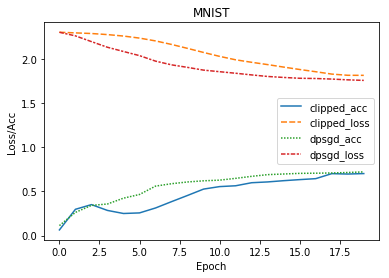

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(data=metrics)
ax.set(xlabel='Epoch', ylabel='Loss/Acc', title='MNIST')
plt.savefig('mnist-{}.png'.format(norm_percentile))